<a href="https://colab.research.google.com/github/AUT-Student/NLP-HW2/blob/main/NLP_HW2_Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Bidirectional, TimeDistributed
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import backend

# Dataset

In [2]:
!gdown 1Px1lQhMgkdeFigxwmqvk1ojJPZpq40u5
!gdown 1WHbpY1Ydqq7yqtQ2YFavR78zsD7nDwbg
!gdown 1pMJQk75R3898sUzFKUMQTPPE_QlllvAY
!gdown 1NMesvM67oiJ6-PpSbtErFanj0JMl_Z50

Downloading...
From: https://drive.google.com/uc?id=1Px1lQhMgkdeFigxwmqvk1ojJPZpq40u5
To: /content/UPC_2016_train.txt
100% 25.4M/25.4M [00:00<00:00, 241MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WHbpY1Ydqq7yqtQ2YFavR78zsD7nDwbg
To: /content/UPC_2016_val.txt
100% 5.47M/5.47M [00:00<00:00, 207MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pMJQk75R3898sUzFKUMQTPPE_QlllvAY
To: /content/UPC_2016_test.txt
100% 5.48M/5.48M [00:00<00:00, 222MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NMesvM67oiJ6-PpSbtErFanj0JMl_Z50
To: /content/vectors.zip
100% 48.2M/48.2M [00:00<00:00, 282MB/s]


In [3]:
def read_dataset(filepath):
  file = open(filepath, "r")

  dataset = [[]]

  item_counter = 0
  end_line = False
  for line in file.readlines():
    line_splitted = line.split()
    if len(line_splitted) == 2:  
      token, tag = line_splitted
      
      dataset[-1].append((token, tag))
    else:
      dataset.append([])
      item_counter += 1

  return dataset[:-1]

In [4]:
train_dataset = read_dataset("/content/UPC_2016_train.txt")
valid_dataset = read_dataset("/content/UPC_2016_val.txt")
test_dataset = read_dataset("/content/UPC_2016_test.txt")

In [5]:
!unzip /content/vectors.zip

Archive:  /content/vectors.zip
replace vectors.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: vectors.txt             


# Dataset Overview

In [6]:
print("Max Length:")
print("train = ", max([len(data) for data in train_dataset]))
print("test  = ", max([len(data) for data in test_dataset]))
print("valid = ", max([len(data) for data in valid_dataset]))

print("\nAvg Length:")
print("train = ", np.mean([len(data) for data in train_dataset]))
print("test  = ", np.mean([len(data) for data in test_dataset]))
print("valid = ", np.mean([len(data) for data in valid_dataset]))

Max Length:
train =  734
test  =  734
valid =  676

Avg Length:
train =  29.24276051743712
test  =  29.4551559468736
valid =  29.323931049921647


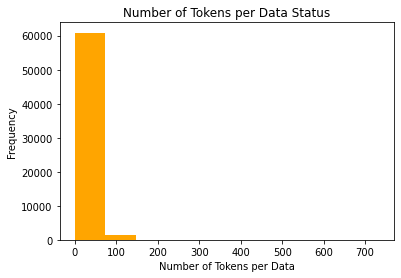

In [7]:
plt.title("Number of Tokens per Data Status")
plt.xlabel("Number of Tokens per Data")
plt.ylabel("Frequency")
plt.hist([len(data) for data in train_dataset], color="orange")
plt.show()

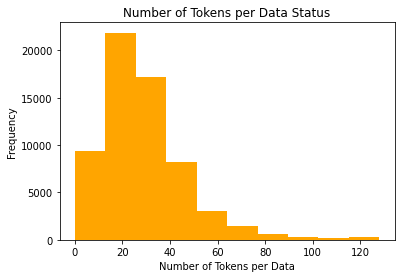

In [8]:
plt.title("Number of Tokens per Data Status")
plt.xlabel("Number of Tokens per Data")
plt.ylabel("Frequency")
plt.hist([min(len(data), 128) for data in train_dataset], color="orange")
plt.show()

In [9]:
print(f"Percent of Long-tail data = {sum([len(data)>64 for data in train_dataset]) * 100 / len(train_dataset)} %")

Percent of Long-tail data = 4.362078063288508 %


# Split Long Data

In [10]:
max_length = 64

In [11]:
def split_long_data(dataset, max_length):
  new_dataset = []
  for data in dataset:
    number_new_data = math.ceil(len(data)/max_length)

    for i in range(number_new_data):
      new_dataset.append(data[i*max_length : min((i+1)*max_length, len(data))])

  return new_dataset

In [12]:
train_dataset = split_long_data(train_dataset, max_length)
test_dataset = split_long_data(test_dataset, max_length)
valid_dataset = split_long_data(valid_dataset, max_length)

# Tag to Index

In [13]:
all_tag = set()

for data in train_dataset:
  for item in data:
    tag = item[1]
    all_tag.add(tag)

In [14]:
tag2index = {tag:i+1 for i, tag in enumerate(all_tag)}
tag2index["PAD"] = 0

# Word to Vec 

In [15]:
file = open("/content/vectors.txt", "r")

word2vector = {}

for i, line in enumerate(file.readlines()):
  line_splitted = line.split()
  word = line_splitted[0]
  vector = np.array(line_splitted[1:], dtype="float")

  word2vector[word] = vector

In [16]:
embedding_size = len(word2vector['#1'])

# Digitalize & Padding

In [17]:
def preprocess(dataset, max_length, embedding_size):
  digitalized_dataset = []
  dataset_X = []
  dataset_y = []

  for data in dataset:
    dataset_X.append([])
    dataset_y.append([])

    for item in data:
      vector = word2vector.get(item[0], np.zeros(embedding_size))
      tag_index = tag2index[item[1]]
      dataset_X[-1].append(vector)
      dataset_y[-1].append(tag_index)

    for _ in range(max_length-len(dataset_y[-1])):
      dataset_y[-1].append(0)
      dataset_X[-1].append(np.zeros(embedding_size))

  return dataset_X, dataset_y

In [18]:
train_X, train_y = preprocess(train_dataset, max_length, embedding_size)
test_X, test_y = preprocess(test_dataset, max_length, embedding_size)
valid_X, valid_y = preprocess(valid_dataset, max_length, embedding_size)

# BiLSTM Model

In [19]:
class BiLSTM(keras.Model):
  def __init__(self, max_length, embedding_size, number_tags):
    super().__init__()
    self.model = Sequential([
                             Input((max_length, embedding_size)),
                             Bidirectional(LSTM(256, return_sequences=True)),
                             TimeDistributed(Dense(number_tags+1, activation="softmax"))
    ])
  
  def call(self, inputs):
    return self.model(inputs)

In [20]:
model = BiLSTM(max_length=max_length, embedding_size=embedding_size, number_tags=len(all_tag))

In [21]:
def ignore_class_accuracy(to_ignore=0):
   # Refrence: https://nlpforhackers.io/lstm-pos-tagger-keras/
  
  def ignore_accuracy(y_true, y_pred):
    y_pred_class = backend.argmax(y_pred, axis=-1)
    y_true_class = backend.argmax(y_true, axis=-1)
    y_true_class = backend.cast(y_true, "int64")

    ignore_mask = backend.cast(backend.not_equal(y_pred_class, to_ignore), 'int32')
    matches = backend.cast(backend.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
    accuracy = backend.sum(matches) / backend.maximum(backend.sum(ignore_mask), 1)
    return accuracy
  
  return ignore_accuracy

In [22]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy", ignore_class_accuracy(0)])

In [23]:
es_callback = EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=3)

In [24]:
train_X_new = np.array(train_X)
valid_X_new = np.array(valid_X)

train_y_new = np.array(train_y)
valid_y_new = np.array(valid_y)

In [ ]:
model.fit(x=train_X_new, y=train_y_new, epochs=1, validation_data=(valid_X_new, valid_y_new), callbacks=[es_callback])

Epoch 1/10
2054/2054 [==============================] - 895s 433ms/step - loss: 0.2656 - accuracy: 0.9218 - ignore_accuracy: 0.8269 - val_loss: 0.1484 - val_accuracy: 0.9554 - val_ignore_accuracy: 0.9001
Epoch 2/10
1356/2054 [==================>...........] - ETA: 4:45 - loss: 0.1324 - accuracy: 0.9604 - ignore_accuracy: 0.9111